In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from world_machine.data import WorldMachineDataset, WorldMachineDataLoader
from world_machine import WorldMachineBuilder
from world_machine.layers import PointwiseFeedforward
from world_machine.train import ParameterScheduler, Trainer, UniformScheduler, CriterionSet
from world_machine.train.stages import (
    GradientAccumulator, LossManager, SensorialMasker, SequenceBreaker,
    ShortTimeRecaller, StateManager)

In [2]:
batch_size = 4
n_epoch = 10

# Data

In [3]:
class StructuralBreakDataset(WorldMachineDataset):
    def __init__(self, data:pd.DataFrame, window_size:int=0, max_sequence_length:int|None=None):

        self._data = data.copy()
        self._window_size = window_size

        ids, counts = np.unique(data.index.get_level_values("id"), return_counts=True)
        size = ids.shape[0]

        if max_sequence_length is None:
            self._max_seq_length = counts.max()
        else:
            self._max_seq_length = max_sequence_length

        sensorial_dimensions = ["value", "period"]

        super().__init__(sensorial_dimensions=sensorial_dimensions, 
                         size=size, 
                         has_state_decoded=False, 
                         has_masks=True)
        
    
    def get_dimension_item(self, dimension, index)-> tuple[torch.Tensor, torch.Tensor]:
        if dimension == "value":
            value = torch.tensor(self._data.loc[index]["value"])
            
            sequence_length = value.shape[0]
            sequence_length = min(sequence_length, self._max_seq_length)
            value = value[:sequence_length]

            item = torch.zeros([self._max_seq_length, 1+(2*self._window_size)])

            item[:sequence_length, 0] = value

            for i in range(0, self._window_size):
                item[:sequence_length, i+1] = torch.roll(value, i+1)

            for i in range(0, self._window_size):
                item[:sequence_length, i+1+self._window_size] = torch.roll(value, -(i+1))

        elif dimension == "period":
            period = torch.tensor(self._data.loc[index]["period"])

            sequence_length = period.shape[0]
            sequence_length = min(sequence_length, self._max_seq_length)
            period = period[:sequence_length]

            item = torch.zeros([self._max_seq_length, 1])
            item[:sequence_length, 0] = period
        
        else:
            raise ValueError(f"No dataset dimension {dimension}.")
        
        targets = torch.roll(item, -1)

        return item, targets

    def get_dimension_mask(self, dimension, index) -> tuple[torch.Tensor, torch.Tensor]:
        if dimension == "value":
            value = self._data.loc[index]["value"]

            sequence_length = value.shape[0]
            sequence_length = min(sequence_length, self._max_seq_length)

            mask = torch.ones(self._max_seq_length, dtype=bool)
            mask[sequence_length-self._window_size:] = False
            mask[:self._window_size] = False

        elif dimension == "period":
            period = self._data.loc[index]["period"]

            sequence_length = period.shape[0]
            sequence_length = min(sequence_length, self._max_seq_length)

            mask = torch.ones(self._max_seq_length, dtype=bool)

            mask[sequence_length:] = False
        else:
            raise ValueError(f"No dataset dimension {dimension}.")

        targets_mask = torch.roll(mask, -1)
        targets_mask[-1] = False

        return mask, targets_mask
        

In [4]:
df = pd.read_parquet("X_train.parquet")

In [5]:
df["value"] = df["value"]/df["value"].abs().max()

In [6]:
shape = len(df)//10

In [7]:
df = df.iloc[:shape]

In [8]:
values, counts = np.unique(df.index.get_level_values("id"), return_counts=True)

In [9]:
ids = np.unique(df.index.get_level_values("id"))
size = ids.shape[0]
size

988

In [10]:
val_df = df.loc[int(0.8*size):]

index_0 = val_df.index.get_level_values(0).to_numpy()
index_0.shape

val_df.index = val_df.index.set_levels(val_df.index.levels[0]-index_0.min(), level=0)

In [11]:
train_df = df.loc[:int(0.8*size)]

In [12]:
train_dataset = StructuralBreakDataset(train_df, window_size=5, max_sequence_length=int(np.median(counts))+100)
val_dataset = StructuralBreakDataset(val_df, window_size=5, max_sequence_length=int(np.median(counts))+100)

In [13]:
train_loader = WorldMachineDataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = WorldMachineDataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [14]:
next(iter(train_loader))

TensorDict(
    fields={
        index: Tensor(shape=torch.Size([4]), device=cpu, dtype=torch.int64, is_shared=False),
        input_masks: TensorDict(
            fields={
                period: Tensor(shape=torch.Size([4, 2505]), device=cpu, dtype=torch.bool, is_shared=False),
                value: Tensor(shape=torch.Size([4, 2505]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([4, 2505]),
            device=None,
            is_shared=False),
        inputs: TensorDict(
            fields={
                period: Tensor(shape=torch.Size([4, 2505, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                value: Tensor(shape=torch.Size([4, 2505, 11]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([4, 2505]),
            device=None,
            is_shared=False),
        target_masks: TensorDict(
            fields={
                period: Tensor(shape=torch.Size([4, 2505]), device=cpu, dtyp

In [15]:
data_loaders = {"train":train_loader, "val":val_loader}

# Model

In [16]:
values, counts = np.unique(df.index.get_level_values("id"), return_counts=True)
max_context_size = counts.max()

In [17]:
state_size = 128

In [18]:
builder = WorldMachineBuilder(state_size, 
                              max_context_size,
                              "alibi",
                              learn_sensorial_mask=False)

In [19]:
builder.add_sensorial_dimension("value", state_size, 
                                 PointwiseFeedforward(input_dim=11, hidden_size=2*state_size, output_dim=state_size),
                                 PointwiseFeedforward(input_dim=state_size, hidden_size=2*state_size, output_dim=11))

builder.add_sensorial_dimension("period", state_size, 
                                 None,
                                 PointwiseFeedforward(input_dim=state_size, hidden_size=2*state_size, output_dim=1))
                                 #torch.nn.Sequential(PointwiseFeedforward(input_dim=state_size, hidden_size=2*state_size, output_dim=1), torch.nn.Sigmoid()))

In [20]:
builder.add_block(2, "value", n_attention_head=4)

In [21]:
builder.remove_positional_encoding = False
builder.state_activation = "tanh"
builder.state_dropout = None

In [22]:
model = builder.build()

In [23]:
model = model.to("cuda")

# Train

In [24]:
stages = []

#stages.append(SensorialMasker(UniformScheduler(0, 1, n_epoch)))
stages.append(StateManager(check_input_masks=True))
#stages.append(SequenceBreaker(1, True))


dimension_sizes = {#"value":11, 
                   "period":1}
criterions = {#"value":torch.nn.MSELoss(), 
              "period":torch.nn.MSELoss()}


#stages.append(ShortTimeRecaller(dimension_sizes, criterions, 2, 2, 2, 2))

stages.append(GradientAccumulator(32//batch_size))

In [25]:
criterion_set = CriterionSet()

criterion_set.add_sensorial_criterion("mse", "value", torch.nn.MSELoss(), train=False)
criterion_set.add_sensorial_criterion("mse", "period", torch.nn.MSELoss(), train=True)#, weight=10)

In [26]:
trainer = Trainer(criterion_set, stages)

In [27]:
optimizer = torch.optim.AdamW(model.parameters(), 5e-4)

In [28]:
#torch.autograd.set_detect_anomaly(True)
history = trainer(model, data_loaders, optimizer, n_epoch)

100%|██████████| 49/49 [00:09<00:00,  5.42it/s]


VAL Epoch [0/10],             Loss: 0.2266


100%|██████████| 197/197 [00:42<00:00,  4.67it/s]


Epoch [1/10],             Loss: 0.2338, Elapsed Time: 42.19 sec


100%|██████████| 49/49 [00:09<00:00,  5.35it/s]


VAL Epoch [1/10],             Loss: 0.2279


100%|██████████| 197/197 [00:42<00:00,  4.66it/s]


Epoch [2/10],             Loss: 0.2866, Elapsed Time: 42.28 sec


100%|██████████| 49/49 [00:09<00:00,  5.30it/s]


VAL Epoch [2/10],             Loss: 0.2778


100%|██████████| 197/197 [00:42<00:00,  4.66it/s]


Epoch [3/10],             Loss: 0.3276, Elapsed Time: 42.28 sec


100%|██████████| 49/49 [00:09<00:00,  5.13it/s]


VAL Epoch [3/10],             Loss: 0.3138


100%|██████████| 197/197 [00:42<00:00,  4.58it/s]


Epoch [4/10],             Loss: 0.3886, Elapsed Time: 43.01 sec


100%|██████████| 49/49 [00:09<00:00,  5.09it/s]


VAL Epoch [4/10],             Loss: 0.3717


100%|██████████| 197/197 [00:42<00:00,  4.61it/s]


Epoch [5/10],             Loss: 0.3700, Elapsed Time: 42.73 sec


100%|██████████| 49/49 [00:09<00:00,  5.14it/s]


VAL Epoch [5/10],             Loss: 0.3569


100%|██████████| 197/197 [00:43<00:00,  4.56it/s]


Epoch [6/10],             Loss: 0.3474, Elapsed Time: 43.19 sec


100%|██████████| 49/49 [00:09<00:00,  5.30it/s]


VAL Epoch [6/10],             Loss: 0.3357


100%|██████████| 197/197 [00:43<00:00,  4.56it/s]


Epoch [7/10],             Loss: 0.3078, Elapsed Time: 43.27 sec


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]


VAL Epoch [7/10],             Loss: 0.3009


100%|██████████| 197/197 [00:43<00:00,  4.56it/s]


Epoch [8/10],             Loss: 0.2745, Elapsed Time: 43.19 sec


100%|██████████| 49/49 [00:09<00:00,  5.19it/s]


VAL Epoch [8/10],             Loss: 0.2663


100%|██████████| 197/197 [00:42<00:00,  4.59it/s]


Epoch [9/10],             Loss: 0.2604, Elapsed Time: 42.96 sec


100%|██████████| 49/49 [00:09<00:00,  5.27it/s]


VAL Epoch [9/10],             Loss: 0.2505


100%|██████████| 197/197 [00:43<00:00,  4.56it/s]


Epoch [10/10],             Loss: 0.2624, Elapsed Time: 43.24 sec


100%|██████████| 49/49 [00:09<00:00,  5.17it/s]

VAL Epoch [10/10],             Loss: 0.2508


In [29]:
history

{'optimizer_loss_train': array([0.23377354, 0.28658748, 0.32763657, 0.38858321, 0.37004194,
        0.34738314, 0.30782905, 0.27452046, 0.26038462, 0.26244417]),
 'optimizer_loss_val': array([0.22793065, 0.27782735, 0.31383482, 0.37171447, 0.35686576,
        0.33565307, 0.30085462, 0.26626837, 0.25048184, 0.25076488]),
 'duration': array([42.19179153, 42.28337097, 42.27552104, 43.00966835, 42.72908592,
        43.19286847, 43.26643682, 43.18664289, 42.96350527, 43.24389791]),
 'value_mse_train': array([0.02167132, 0.02553939, 0.03151787, 0.03446272, 0.03648868,
        0.03937245, 0.04299256, 0.042432  , 0.03896057, 0.0359075 ]),
 'value_mse_val': array([0.02200588, 0.02609086, 0.03200143, 0.0354589 , 0.03780385,
        0.04103893, 0.0443793 , 0.0438081 , 0.03974181, 0.03640546]),
 'period_mse_train': array([0.23377354, 0.28658748, 0.32763657, 0.38858321, 0.37004194,
        0.34738314, 0.30782905, 0.27452046, 0.26038462, 0.26244417]),
 'period_mse_val': array([0.22793065, 0.27782735

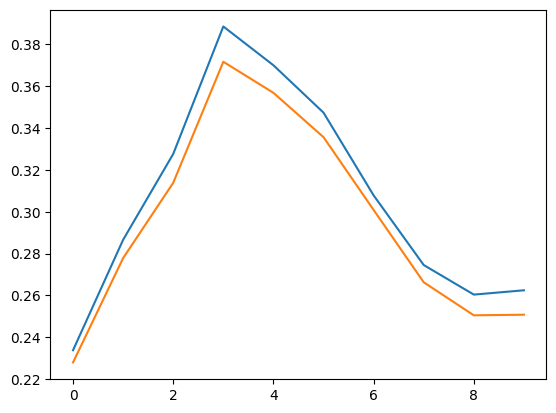

In [30]:
plt.plot(history["period_mse_train"])
plt.plot(history["period_mse_val"])

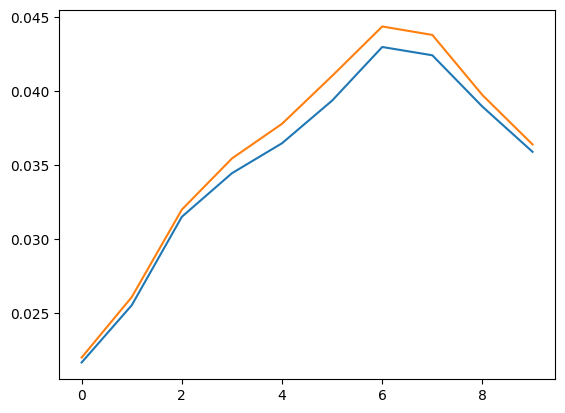

In [31]:
plt.plot(history["value_mse_train"])
plt.plot(history["value_mse_val"])

In [32]:
item = next(iter(train_loader))

In [33]:
item = item.to("cuda")

In [34]:
shape

2371573

In [35]:
state = torch.zeros([4, 2505, state_size], device="cuda")

In [36]:
model = model.eval()

In [56]:
with torch.no_grad():
    logits = model.inference(state[:,:1600], sensorial_data=item["inputs"][:,:1600], sensorial_masks=item["input_masks"][:,:1600])

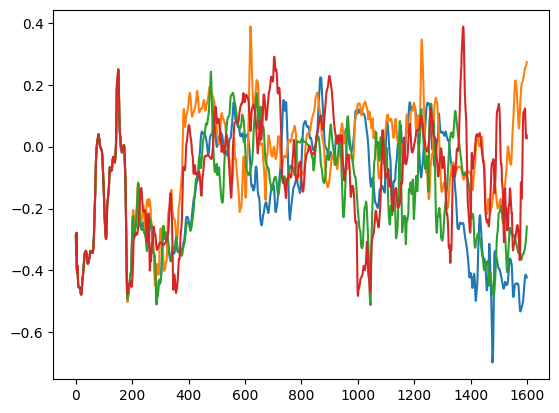

In [57]:
plt.plot(logits["period"][0].cpu())
plt.plot(logits["period"][1].cpu())
plt.plot(logits["period"][2].cpu())
plt.plot(logits["period"][3].cpu())

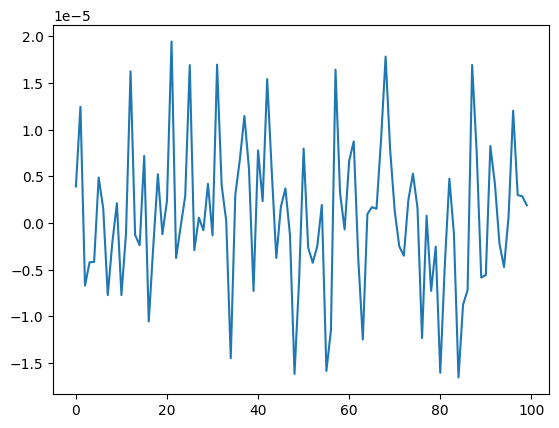

In [39]:
plt.plot(item["inputs"][:,:100]["value"][0,:,0].cpu())

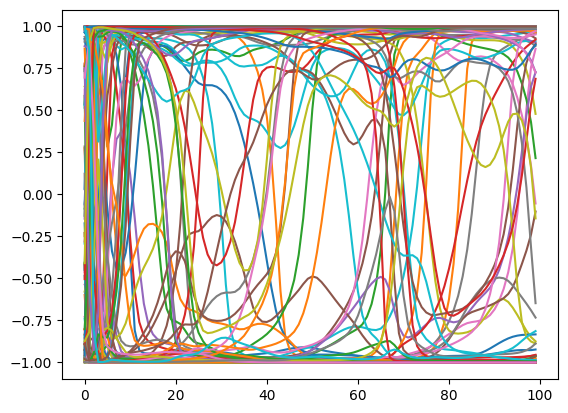

In [40]:
for i in range(100):
    plt.plot(logits["state"][0,:,i].cpu())

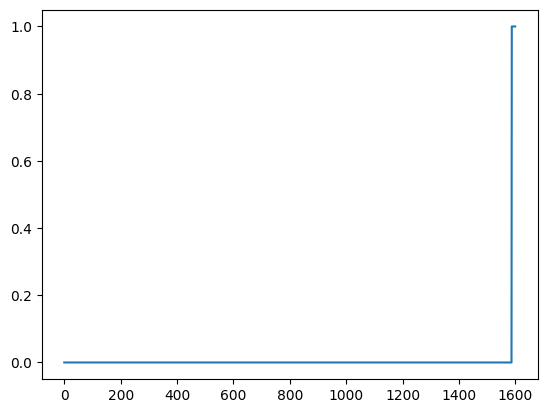

In [55]:
plt.plot(item["inputs"]["period"][0,:1600,0].cpu())

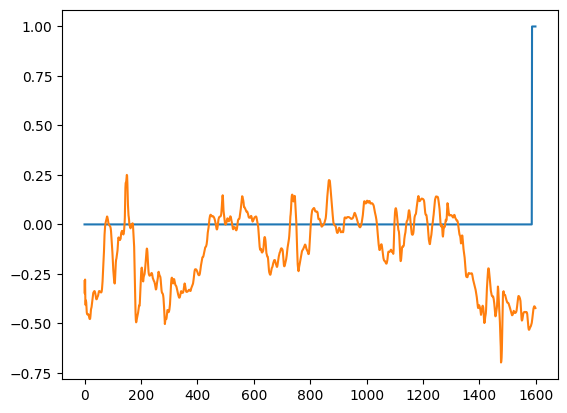

In [59]:
plt.plot(item["inputs"]["period"][0,:1600,0].cpu())
plt.plot(logits["period"][0].cpu())

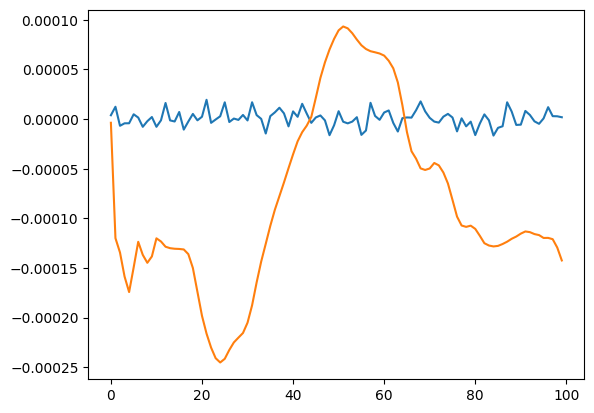

In [49]:
plt.plot(item["inputs"]["value"][0,:100,0].cpu())
plt.plot(logits["value"][0,:,0].cpu()/1e3)
